# **6610210301 ภานุพงศ์ สนไชย**

# Lab05 - Descriptors

In this exercise, we will learn how to implement several detectors that are robust to scale, rotation, and intesity changes. We also take a look at how SIFT descriptors are created. We will:

1. Implement multi-scale Harris corner detector
2. Implement multi-scale blob detector using LoG
3. Implement multi-scale blob detector using DoG
4. Implement SIFT-like descriptors


## 5.0 Setup and Utility Functions

First, make sure you have installed the required libraries and check what is your *present working directory*:

In [1]:
!pip install numpy pillow
!echo "Your current directory is: $(pwd)"

Your current directory is: /content


You are provided with some utility functions for reading, writing, and rendering images.

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, gaussian_filter, laplace
import colorsys

%matplotlib inline


"""
Utility functions to read, to display, and to save an image
"""
def read_img(path, greyscale=True):
    img = Image.open(path)
    if greyscale:
        img = img.convert('L')
    else:
        img = img.convert('RGB')
    return np.array(img).astype(float)


def show_img(img_array, cmap=None, title=""):
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.title(title)
    if cmap is None:
        img_array = img_array - img_array.min()
        img_array = img_array / img_array.max()
        img_array = (img_array * 255).astype(np.uint8)
        plt.imshow(img_array, cmap="gray", vmin=0, vmax=255)
    else:
        plt.imshow(img_array, cmap=cmap, vmin=0, vmax=255)
    plt.show()


def save_img(img, path):
    img = img - img.min()
    img = img / img.max()
    img = (img * 255).astype(np.uint8)
    img = Image.fromarray(img)
    img.save(path)
    print(path, "is saved!")


"""
Single scale Harris corner detector (taken from previous Lab)
"""
def harris_detector(
    image,
    alpha=0.04,
    sigma=1.0,
    threshold=0.4):

    # Compute gradients
    dx = np.gradient(image, axis=1)
    dy = np.gradient(image, axis=0)

    # Compute products of derivatives
    Ixx = gaussian_filter(dx * dx, sigma)
    Iyy = gaussian_filter(dy * dy, sigma)
    Ixy = gaussian_filter(dx * dy, sigma)

    # Harris response
    detM = (Ixx * Iyy) - (Ixy ** 2)
    traceM = Ixx + Iyy
    R = detM - alpha * (traceM ** 2)

    # Remove negative response (edge)
    R = np.where( R > 0, R, 0)

    # Normalize response
    R = R / R.max()

    # Response thresholding
    filtered_response = np.where( R > threshold, R, 0)

    return filtered_response


"""
Convert image pyramid into scale space
Input
  pyramid: image pyramid (list of images (HxW))
Output
  scale_space: HxWxS where S the number of elements in the input list
"""
def pyramid_to_scale_space(pyramid):
    scale_space = pyramid[0]
    for i in range(len(pyramid)-1):
        scaled_arr = np.zeros((pyramid[i+1].shape[0]*2**(i+1),
                               pyramid[i+1].shape[1]*2**(i+1)))
        scaled_arr[::2**(i+1), ::2**(i+1)] = pyramid[i+1]
        scaled_arr.resize(pyramid[0].shape)
        scale_space = np.dstack((scale_space, scaled_arr))

    return scale_space


"""
Visualizes the maxima on a given image
Input
  image: image of size HxW
  maxima: list of (x,y) tuples; x<W, y<H
  file_path: path to save image. if None, display to screen
Output
  None
"""
def visualize_maxima_multi_scale(image, maxima):
    H, W = image.shape
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap="gray")
    for maximum in maxima:
        y, x, s = maximum
        assert x < W and y < H and x >= 0 and y >= 0
        radius = 2**(s+1)
        # radius = 1
        circ = plt.Circle((x, y), radius, color='r', fill=False)
        ax.add_patch(circ)

    plt.show()


"""
Visualizes the scale space
Input
  scale_space: list of images in different scales
"""
def display_layers(scale_space):
    num_layers = len(scale_space)
    plt.figure(figsize=(15, 5))

    for i in range(num_layers):
        plt.subplot(1, num_layers, i + 1)
        plt.imshow(scale_space[i], cmap="gray")
        plt.title(f'Layer {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## 5.1 Multi-scale Harris Corner Detector

In this section, we will extend the `harris_detector` function in previous Lab to create multi-scale Harris corner detector.

**Step 1:** Construct an image pyramid (create multiple versions of the image at different scales)

Size of layer 0 is (389, 600)
Size of layer 1 is (194, 300)
Size of layer 2 is (97, 150)
Size of layer 3 is (48, 75)


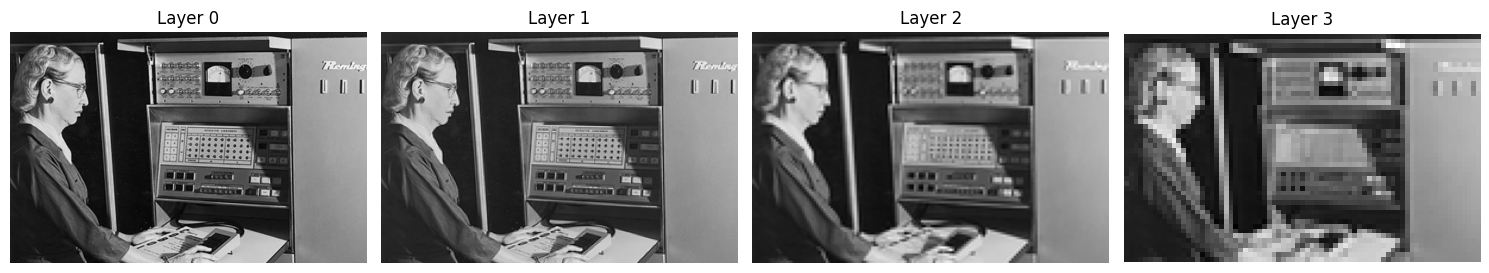

In [17]:
"""
Down-sampling of an image by a scale of 2 and creates an image pyramid
Input
  image: image
  num_layers: number of layers in the pyramid
Output:
  pyramid: image pyramid (list of image in different scale)
"""
def create_image_pyramid(image, num_layers):
    # Load the image
    original_array = image.astype(float)

    # Initialize a list to hold the pyramid layers
    pyramid = [original_array]

    # TODO: create image pyramid where the next layer is the down sample by
    # half of the current layer
    for i in range(1,num_layers):
      #need to convert img to pil image for implement
        pil_image=Image.fromarray(pyramid[i-1]) #แปลงให้เป็น 1 เพราะตัวที่0 ลย ให้ติดเลบไม่ได้
        down_size=(pil_image.width//2,pil_image.height//2)
        down_image=pil_image.resize(down_size,Image.LANCZOS)
        pyramid.append(np.array(down_image).astype(float))

    return pyramid


# Multi-scale Harris corner detector
image = read_img('grace_hopper.png')
num_layers = 4  # Define the number of layers

# -- Step 1: Create Image Pyramid --
pyramid = create_image_pyramid(image, num_layers)
for i in range(num_layers):
    print(f"Size of layer {i} is {pyramid[i].shape}")
display_layers(pyramid)

**Step 2:** Apply the Harris corner detection algorithm to each level of the image pyramid

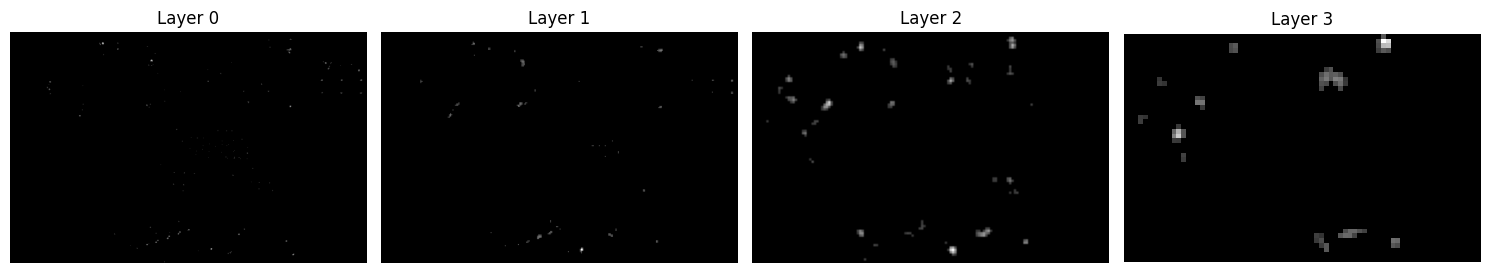

In [18]:
# -- Step 2: Harris Corner Detection at Each Scale --
# Apply harris_detector function to each layer of the pyramid
# and append the result into corners_pyramid
response_pyramid = []
for i in range(num_layers):
    corners_image = harris_detector(pyramid[i], alpha=0.04, sigma=1.0, threshold=0.2)
    response_pyramid.append(corners_image)

# Display Harris response for each layer
display_layers(response_pyramid)

**Step 3:** Perform non-maximum suppression to eliminate redundant detections

**Step 4:** Select the most appropriate scale for each detected corner (based on the strength of the corner response or other criteria)

Number of maxima: 103


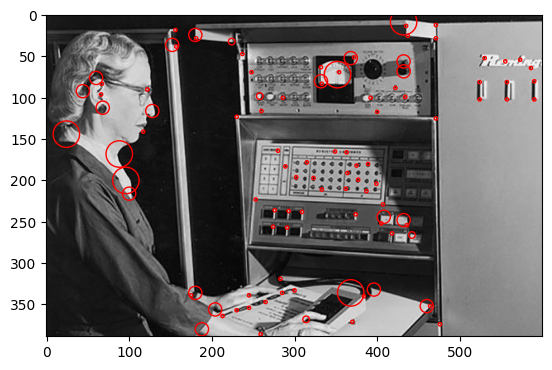

In [28]:
"""
Extract the peak x,y locations from scale space
Input
  scale_space: Scale space of size HxWxS
  k: neighborhood in x and y
  ks: neighborhood in scale
Output
  list of (x,y) tuples; x<W and y<H
"""
#ไม่ไดู้กระดานคับ
# def find_maxima_multi_scale(scale_space, k_xy=10, k_s=1):
#     H, W, S = scale_space.shape

#     # TODO: Find maxima in both spatial and scale spaces
#     maxima = []
#     for i in range(H):
#         for j in range(W):
#             for s in range(S): #มี spaceเพิ่มขึ้นมา
#                 space = scale_space[i-k_xy:i+k_xy,:j-k_xy:j+k_xy,s]
#                 center=scale_space[i,j,s]
#                 num=np.prod(space.shape)-1
#                 if np.sum(center>space)==num:
#                   maxima.append((i,j))
#     return maxima
#ประยุกหมายเลข2
def find_maxima_multi_scale(scale_space, k_xy=10, k_s=1):
    H, W, S = scale_space.shape

    # TODO: Find maxima in both spatial and scale spaces
    maxima = []
    for i in range(H):
        for j in range(W):
            for s in range(S): #มี spaceเพิ่มขึ้นมา
                space = scale_space[max(0,i-k_xy):min(H,i+k_xy+1)#ทำไมต้องบวก1
                                    ,max(0,j-k_xy):min(W,j+k_xy+1)
                                    ,max(0,s-k_s):min(S,s+k_s+1)]
                center=scale_space[i,j,s]
                num=np.prod(space.shape)-1
                if np.sum(center>space)==num:
                  maxima.append((i,j,s))
    return maxima

# -- Step 3: Find maxima --
response_scale_space = pyramid_to_scale_space(response_pyramid)
maxima = find_maxima_multi_scale(response_scale_space, k_xy=10, k_s=1)
print(f"Number of maxima: {len(maxima)}")

# -- Step 4: Visulaize --
visualize_maxima_multi_scale(image, maxima)

## 5.2 Laplacian of Gaussian (LoG)

The Laplacian of Gaussian (LoG) is represented by the formula

$$\text{LoG}(x,y)=\frac{1}{\pi\sigma^4} \left( \frac{x^2 + y^2}{2\sigma^2} - 1) \right) e^{(-\frac{x^2 + y^2}{2\sigma^2})}$$

which is derived by applying the Laplacian operator to a 2D Gaussian function $g(x,y) = \frac{1}{2\pi\sigma^2} e^{(-\frac{x^2 + y^2}{2\sigma^2})}$.

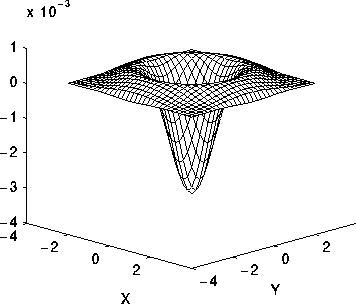

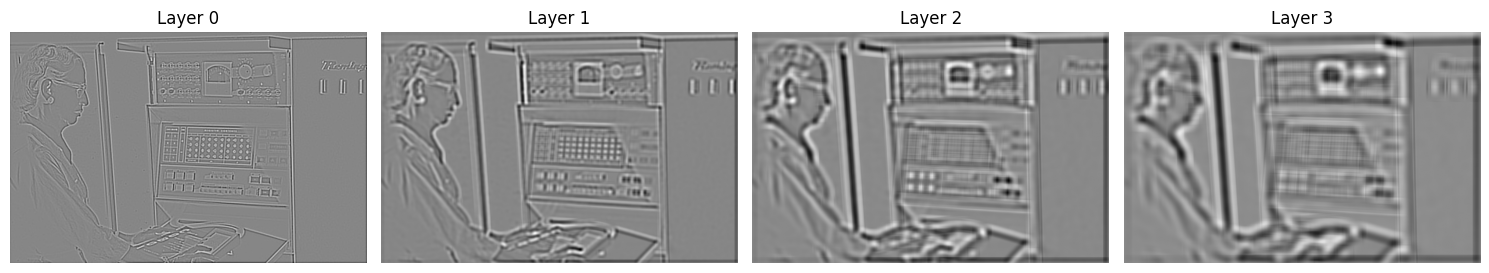

In [34]:
def gaussian_kernel(variance):
    kernel_size = int(2 * np.ceil(2 * np.sqrt(variance)) + 1)
    ax = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * variance)) / (2 * np.pi * variance)
    kernel /= np.sum(kernel)

    return kernel

def log_kernel(sigma):
    # TODO: create LoG kernel
    gaussian=gaussian_kernel(sigma**2)
    log = laplace(gaussian,mode='reflect')

    return log

# Test LoG with different values of sigma
disp_LoG = []
for i in range(1,8,2):
    kernel_LoG = log_kernel(float(i))

    # TODO: calculate response image
    response_LoG = convolve(image,kernel_LoG,mode="constant",cval=0.0)
    #normalize
    Nresponse_LoG=(response_LoG-response_LoG.min())/(response_LoG.max())
    disp_LoG.append(Nresponse_LoG)

display_layers(disp_LoG)

Another way to implement LoG:

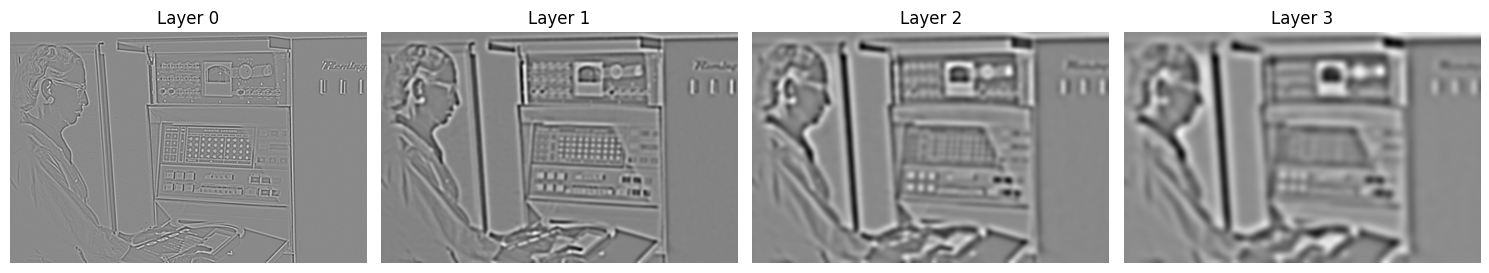

In [35]:
def laplacian_of_gaussian(image, sigma):
    # TODO: Apply Gaussian filter to the image
    gaussian_img = gaussian_filter(image,sigma=sigma)

    # Compute the Laplacian of the Gaussian-filtered image
    LoG_img = laplace(gaussian_img)
    LoG_img=(LoG_img-LoG_img.min())/LoG_img.max()
    return LoG_img

# Test LoG with different values of sigma
disp_LoG = []
for i in range(1,8,2):
    response_LoG = laplacian_of_gaussian(image, i)
    disp_LoG.append(response_LoG)

display_layers(disp_LoG)

## 5.3 Difference of Gaussian (DoG)

The DoG is computed by taking the difference between two Gaussian-blurred images, each with different standard deviations ($\sigma_1$ and $\sigma_2$):

$$\text{DoG}(x,y)=g(x,y;\sigma_1)-g(x,y;\sigma_2)$$

This subtraction emphasizes edges and transitions in intensity.

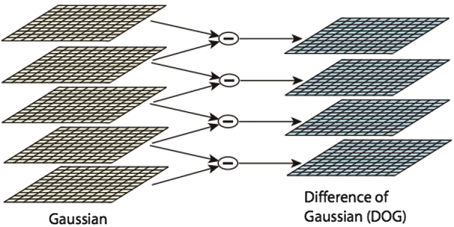

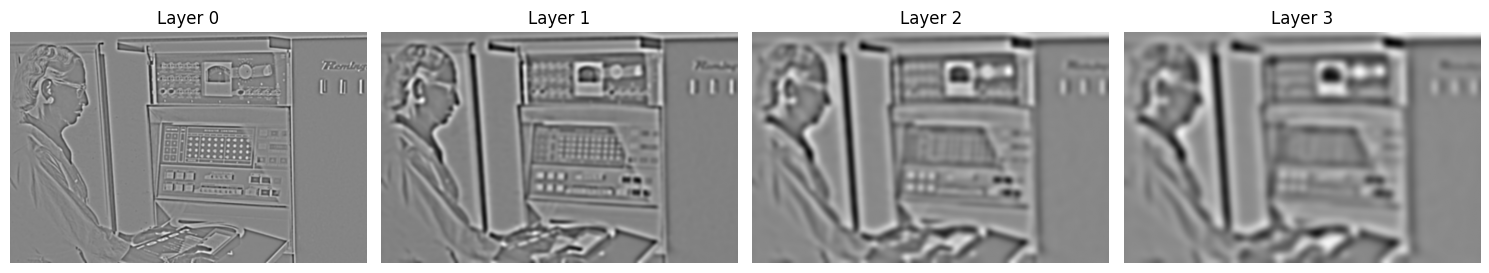

In [38]:
def difference_of_gaussian(image, sigma1, sigma2):
    # TODO: Compute the Difference of Gaussian
    gaussian_1= gaussian_filter(image,sigma=sigma1)
    gaussian_2= gaussian_filter(image,sigma=sigma2)
    DoG = gaussian_2-gaussian_1
    DoG=(DoG-DoG.min())/DoG.max()
    return DoG

# Test DoG with different values of sigma
disp_DoG = []
for i in range(1,8,2):
  response_DoG = difference_of_gaussian(image, i, i+2)
  disp_DoG.append(response_DoG)

display_layers(disp_DoG)

## 5.4 Blob Detector

A blob detector is an image processing technique used to identify and locate regions in an image that differ in properties, such as brightness or color, compared to surrounding areas.

**Step 1:** Apply the blob detection method (LoG/DoG) to identify potential blobs in the image:

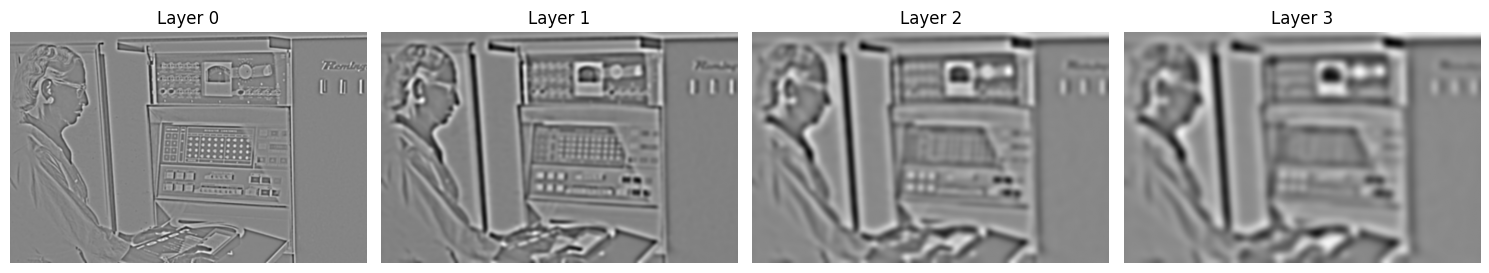

In [46]:
# Blob Detector
image = read_img('grace_hopper.png')
num_layers = 4
step_sigma = 2
min_sigma = 1
max_sigma = min_sigma + (step_sigma * (num_layers-1))

# -- Step 1: Apply blob detection method (LoG/DoG) --
responses = []
for i in range(min_sigma, max_sigma + 1, step_sigma):
    # TODO: Choose either LoG or DoG
    response = difference_of_gaussian(image,i,i+step_sigma) #why not +1
    responses.append(response)

display_layers(responses)

**Step 2:** Set intensity thresholds to filter out weak blobs.

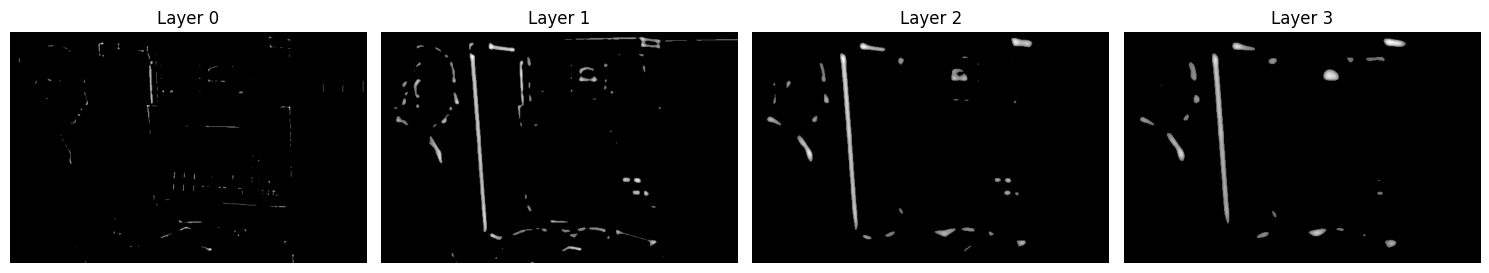

In [64]:
threshold = 0.4

# -- Step 2: Filter out blobs with weak response --
threshold_responses = []
for i in range(num_layers):
    # TODO: Intensity thresholding
    inv_response=1-responses[i]
    threshold_response = np.where(inv_response > threshold, inv_response, 0)
    threshold_responses.append(threshold_response)

display_layers(threshold_responses)

**Step 3:** Perform non-maximum suppression to eliminate redundant detections

**Step 4:** Select the most appropriate scale for each blob (based on the strength of the response)

Number of maxima: 132


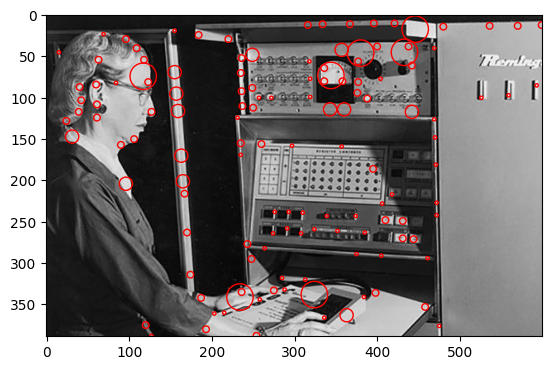

In [65]:
# -- Step 3: Find maxima --
# TODO: perform non-maximum suppression
scale_space=np.dstack(threshold_responses)
maxima = find_maxima_multi_scale(scale_space,k_xy=10,k_s=1)
print(f"Number of maxima: {len(maxima)}")

visualize_maxima_multi_scale(image, maxima)

## 5.5 Scale-Invariant Feature Transform (SIFT)

OpenCV provides a robust implementation of the Scale-Invariant Feature Transform (SIFT) algorithm, making it easy to detect keypoints and compute descriptors in images. There are two main functions you can use to apply SIFT:

1. `SIFT_create()` Initialize SIFT detector.
2. `detectAndCompute()` Detect keypoints and computes their descriptors in one step.

Number of keypoints: 1665


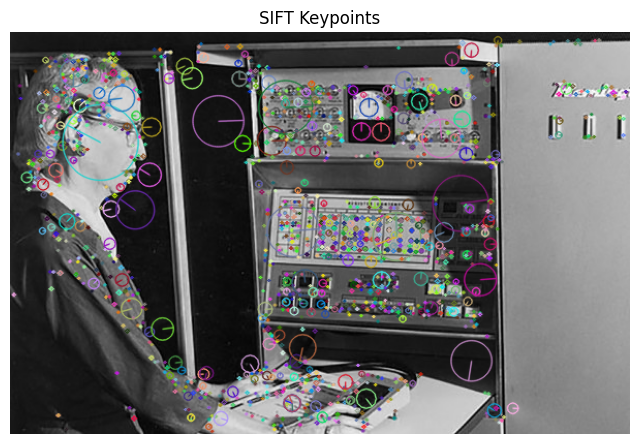

In [66]:
import cv2
import matplotlib.pyplot as plt

# Load an image from a file
image = cv2.imread('grace_hopper.png')  # Replace with your image path
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

# TODO: Initialize SIFT detector
sift = cv2.SIFT_create()

# TODO: Detect keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(image,None)#mask
print(f"Number of keypoints: {len(keypoints)}")

# Draw keypoints on the image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Plot the results
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('SIFT Keypoints')
plt.axis('off')
plt.show()

### Changing Parameters in SIFT Using OpenCV

OpenCV allows you to customize various parameters to optimize feature detection based on your specific needs. You can adjust these parameters when creating the SIFT object using the cv2.SIFT_create() function.

Here are the key parameters you can modify when initializing the SIFT detector:

*   **nfeatures (int):** Specify the number of best features to retain. The default is 0, which means all features are retained. Setting this to a positive integer limits the number of keypoints detected.
*   **nOctaveLayers (int):** Specify The number of layers in each octave. The default is 3. Increasing this value can improve the detection of features at different scales but may increase computation time.
*   **contrastThreshold (float):** Define the threshold used to filter out weak keypoints based on contrast. The default is 0.04. Lowering this value may result in more keypoints being detected, while increasing it will reduce the number of keypoints.
*   **edgeThreshold (float):** Define the threshold used to filter out keypoints that are too close to edges. The default is 10. Increasing this value may allow more keypoints near edges, while decreasing it will filter them out.
*   **sigma (float):** Specify the strength of the Gaussian blur applied to the image before keypoint detection. The default is 1.6. Adjusting this value can help in detecting features at different scales.


Number of keypoints: 500


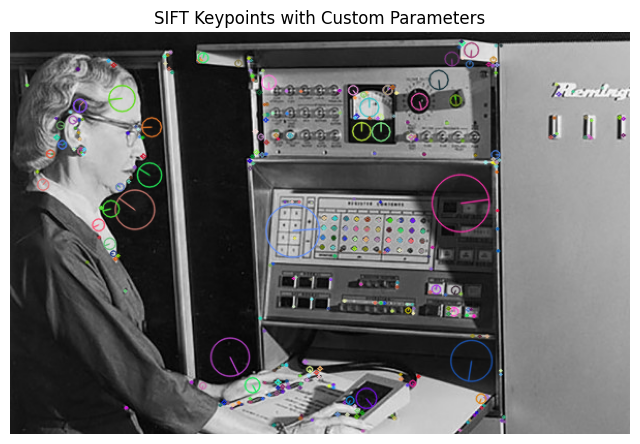

In [67]:
# TODO: Initialize SIFT with following parameters:
#  - nfeatures = 500
#  - nOctaveLayers = 4
#  - contrastThreshold = 0.03
#  - edgeThreshold = 15
#  - sigma = 1.6
sift = cv2.SIFT_create(nfeatures = 500,
                       nOctaveLayers = 4,
                       contrastThreshold = 0.03,
                       edgeThreshold = 15,
                       sigma = 1.6)
#NFEATURE FIND BEST 500 POINT DUU JAK NAI
# TODO: Detect keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(image,None)#mask
print(f"Number of keypoints: {len(keypoints)}")

# Draw keypoints on the image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Plot the results
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('SIFT Keypoints with Custom Parameters')
plt.axis('off')
plt.show()

### Compare Descriptors of Keypoints in two images

In this example, we will compare the descriptors of a pair of keypoints. We will visualize the keypoints and their corresponding descriptors to understand how they differ.

Keypoint 172: (244.31106567382812, 37.002532958984375)
Descriptor 172: [  9.  13.  18.  16.   8.  11.   9.   9.   1.   0.  12.  37.  18.  11.
  15.   5.   0.   0.  20.  17.   4.   4.  39.   3.   0.   2.  16.  12.
   0.   2.  40.   6.  32.  29.  37.  27.   7.   8.   3.  10. 124.   4.
  12.  23.   5.  15. 100. 139.   9.   0.   3.   2.   5.  97. 146.  39.
   0.   0.   0.   1.   0.  11. 146.  27.  75.   4.   0.   0.  18.  35.
  16.  33. 146.  39.   0.   0.  10.  28.  15.  52.  82.   6.   0.   0.
  26. 146.  47.  19.   0.   0.   0.   0.   2.  49.  94.   8.  27.   3.
   1.   1.  10.  48.  46.  61. 146.  24.   1.   0.  12.  35.  17.  48.
 124.   7.   0.   0.   2.  85.  41.  26.   0.   0.   0.   0.   0.  60.
  92.   2.]

Keypoint 319: (385.5971984863281, 180.9028778076172)
Descriptor 319: [  1.  16.  70.  39.   4.   3.   1.   0.  67. 111.  40.   1.   2.   1.
   0.   3. 155.  29.   1.   0.   0.   0.   0.  51.  48.   8.   0.   0.
   0.   0.   0.  10.   2.  16.  17.   8.   9.   4.   1.   1. 155. 

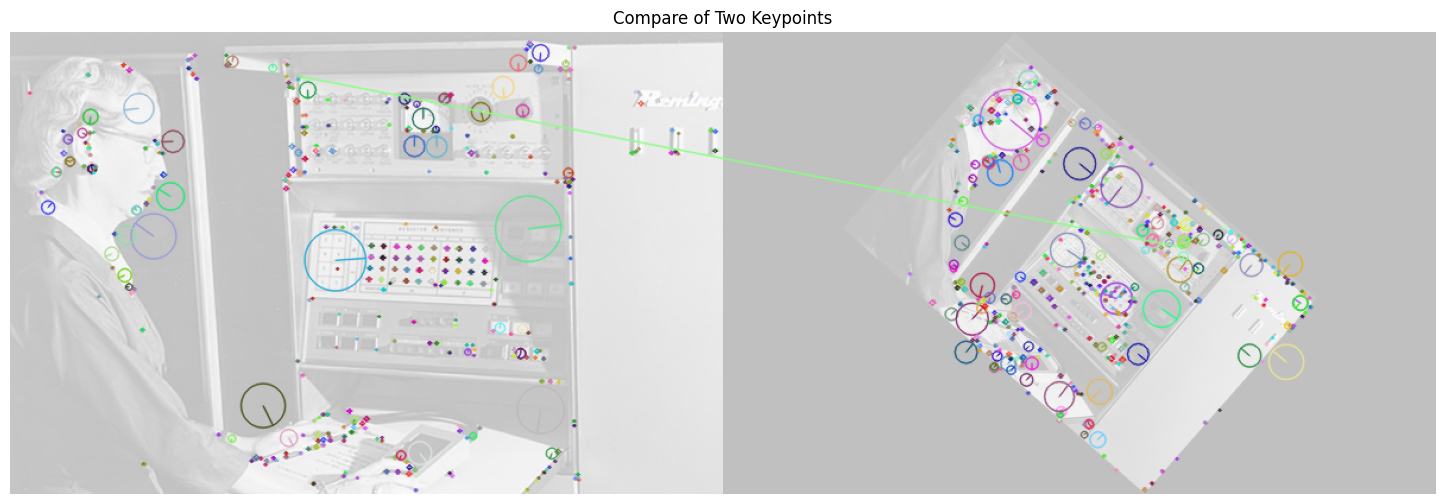

In [115]:
from re import S
import random

def compare_two_keypoints(image1, image2):

    # Initialize SIFT detector with nfeatures = 200
    sift = cv2.SIFT_create(nfeatures = 500,
                       nOctaveLayers = 4,
                       contrastThreshold = 0.03,
                       edgeThreshold = 15,
                       sigma = 1.6)

    # TODO: Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(image1,None)#mask
    keypoints2, descriptors2 = sift.detectAndCompute(image2,None)#mask

    indx1 = random.randint(0, len(keypoints1)-1)
    indx2 = random.randint(0, len(keypoints2)-1)

    keypoint1 = keypoints1[indx1]
    keypoint2 = keypoints2[indx2]

    descriptor1 = descriptors1[indx1]
    descriptor2 = descriptors2[indx2]

    # Calculate the Euclidean distance between the two descriptors
    distance = np.linalg.norm(descriptor1-descriptor2)

    # Print keypoint information and distance
    print(f"Keypoint {indx1}: {keypoint1.pt}")
    print(f"Descriptor {indx1}: {descriptor1}")
    print(f"\nKeypoint {indx2}: {keypoint2.pt}")
    print(f"Descriptor {indx2}: {descriptor2}")
    print(f"\nEuclidean Distance between descriptors: {distance}\n")

    # Create DMatch object
    match = cv2.DMatch()

    # Set the indices for the match
    match.queryIdx = indx1  # Index of keypoint1 in keypoints1
    match.trainIdx = indx2  # Index of keypoint2 in keypoints2
    match.distance = distance  # Calculated distance

    # Draw matches
    matches = [match]  # Create a list of matches
    pale_image1 = np.uint8(image1 / 4.0 + 192.0)
    pale_image2 = np.uint8(image2 / 4.0 + 192.0)
    image_matches = cv2.drawMatches(pale_image1, keypoints1, pale_image2, keypoints2, matches, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Plot the results
    # Plot the results
    plt.figure(figsize=(20, 6))
    plt.imshow(cv2.cvtColor(image_matches, cv2.COLOR_BGR2RGB))
    plt.title('Compare of Two Keypoints')
    plt.axis('off')
    plt.show()

# Test compare_two_keypoints
image1 = cv2.cvtColor(cv2.imread('grace_hopper.png'), cv2.COLOR_BGR2GRAY)
image2 = cv2.cvtColor(cv2.imread('grace_hopper_rotated_scaled.png'), cv2.COLOR_BGR2GRAY)
compare_two_keypoints(image1, image2)